# Predictive Modelling: XGBoost

# Imports

In [585]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

#
from IPython.display import display, clear_output
import sys
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position
from src.visualization.visualize import plot_confusion_matrix
from atomm.Methods import BlockingTimeSeriesSplit, PurgedKFold           


import time, os

# scikit-learn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For BayesianHyperparameter Optimization
from src.models.hyperparameter_optimization import search_space, BayesianSearch

# Feature building tool
from src.features.build_features import calcIndicators


# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
# Load environment variables
load_dotenv(find_dotenv())

True

## Defining functions

In [21]:
def run_combinations(
        symbol,
        forecast_horizon,
        input_window_size,
        X_train,
        X_test,
        y_train,
        y_test,
        prices,
        model,
        hyper_optimize=False,
        n_eval=10,
        silent = False,
    
    ):
    start = time.time()
    cnt = 1
    df_score = pd.DataFrame(index=forecast_horizon, columns=input_window_size, dtype=float)
    df_score.rename_axis('Forecast horizon (days)').rename_axis('Input window (days)', axis=1)
    df_returns = df_score.copy()
    total = len(forecast_horizon)*len(input_window_size)
    # Loop over forecast horizons
    try:
        for i, fh in enumerate(forecast_horizon):
            # Loop over input / lookback windows
            for j, iw in enumerate(input_window_size):

                params = {}
                if hyper_optimize:
                    _, _, params = BayesianSearch(
                        search_space(model),
                        model,
                        X_train[symbol][[f'{x}_{iw}' for x in ti_list]], 
                        y_train[symbol][f'signal_{fh}'], 
                        X_test[symbol][[f'{x}_{iw}' for x in ti_list]],
                        y_test[symbol][f'signal_{fh}'],
                        num_eval=n_eval,
                        silent=True,
                    )
                clf = model(**params)
                clf.fit(X_train[symbol][[f'{x}_{iw}' for x in ti_list]], y_train[symbol][f'signal_{fh}'])
                y_pred = clf.predict(X_test[symbol][[f'{x}_{iw}' for x in ti_list]])
                # Calculate accuracy score ()
                a_score = accuracy_score(y_test[symbol][f'signal_{fh}'], y_pred)
                # Calculate returns generated by stratedy
                returns = calc_returns(y_pred, prices[symbol])
                cum_returns = returns['Cum_Returns_Strat'][-1]
                df_score.iloc[i, j] = a_score
                df_returns.iloc[i, j] = cum_returns
                if silent == False:
                    clear_output(wait=True)
                    display(f'Leg [{cnt} / {total}]; Test Score {a_score}; Test Returns {cum_returns}')
                cnt += 1
    except (KeyboardInterrupt, SystemExit):
        sys.exit(0)
    print(f'Elapsed time {round(time.time()-start, 0)}s.')
    return df_score, df_returns

In [5]:
def avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model,
    silent = False
):
    results_dict, returns_dict = {}, {}
    cnt = 1
    start = time.time()
    for symb in symbol_list:
        results, returns = run_combinations(
            symb,                             
            forecast_horizon,                                 
            input_window_size,                                  
            X_train,    
            X_test,    
            y_train,    
            y_test,    
            prices_test,   
            model=model,
            silent=True
        )
        results_dict[symb] = results
        returns_dict[symb] = returns
        avg_results = pd.DataFrame(
            np.array([results_dict[x].values for x in results_dict.keys()]).mean(axis=0),
            columns=results.columns, index=results.index).style.background_gradient(cmap='BuGn')
        
        if silent == False:
            clear_output(wait=True)
            display(f'Leg [{cnt}/{len(symbol_list)}]; Elapsed Time {round(time.time()-start , 0)}s\n', avg_results)
        cnt += 1

    return avg_results, results_dict, returns_dict

In [51]:
def create_two_class_signal(df, symbol_list):
    df_signals = pd.DataFrame(pd.MultiIndex.from_product([[], []]),)# index=df.index)
    sign_dic = {}
    for symbol in symbol_list:
        data = df[symbol]
        dicti = {}
        for n in forecast_horizon:
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            signal = np.where(diff > 0, 1, 0)
            dicti[f'signal_{n}'] = signal
        sign_df = pd.DataFrame.from_dict(dicti)
        sign_dic[symbol] = sign_df
    df_signals = pd.concat(sign_dic.values(), keys=sign_dic.keys(), axis=1)
    return df_signals

In [57]:
def create_three_class_signal(df, symbol_list, threshold=None, multi=1):
    df_signals = pd.DataFrame(pd.MultiIndex.from_product([[], []]),)# index=df.index)
    df_op = df_signals.copy()
    sign_dic, op_dic = {}, {}
    for symbol in symbol_list:
        data = df[symbol]
        dicti, dict_op = {}, {}
        for n, thresh in zip(forecast_horizon, threshold):
            diff = (data['Close'].shift(-n) - data['Close'])/data['Close']
            signal1p = np.where(diff > multi*thresh/100, 1, 0)
            signal1n = np.where(diff < -multi*thresh/100, -1, 0)
            signal = signal1p + signal1n
            open_position = calc_open_position(signal)
            dicti[f'signal_{n}'] = signal
            dict_op[f'open_position_{n}'] = open_position
        sign_dic[symbol] = pd.DataFrame.from_dict(dicti)
        op_dic[symbol] = pd.DataFrame.from_dict(dict_op)
    df_signals = pd.concat(sign_dic.values(), keys=sign_dic.keys(), axis=1)
    df_op = pd.concat(op_dic.values(), keys=op_dic.keys(), axis=1)
    return df_signals, df_op

In [6]:
def calc_returns(signals, prices):
    returns = prices[['Close']].pct_change()
    returns['Signal_Strat'] = calc_open_position(signals)
    returns['Cum_Returns_Strat'] = (returns['Signal_Strat'] * returns['Close']).cumsum()
    returns['Cum_Returns_BH'] = returns['Close'].cumsum()
    return returns

## Loading the data

In [ ]:
from src.data.tools import check_for_missing_vals

In [299]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
threshold_list = [0.63, 1.15, 1.49, 1.79, 2.14, 2.65, 3.08, 3.48, 3.94]
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']
ti_list = ['sma', 'rsi', 'stoc', 'roc', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']

symbol_list = df_moments.columns.get_level_values(0).unique()
symbol_list = ['GPS']
startd = datetime.datetime(2002, 1, 29)
endd = datetime.datetime(2012, 7, 30)

In [39]:
start = time.time()
df = pd.DataFrame(pd.MultiIndex.from_product([[], []]))
dic = {} 
#symb_list = dm.ReturnIndexConstituents('DJIA')+['DJIA']
for symb in symbol_list:
    #print(symb)
    symb_df = dm.ReturnData(
        symb,
        start_date=startd,
        end_date=endd,
        limit=None)
    dic[symb] = symb_df
    
prices = pd.concat(dic.values(), keys=dic.keys(), axis=1)
print(f'Elapsed time: {int(time.time()-start)}s')

Elapsed time: 0s


In [115]:
check_for_missing_vals(prices)

No missing values found in dataframe


In [591]:

def calcIndicators2(data, symbol, lookback_windows, ti_list):
    mi = MomentumIndicators(data[symbol])
    df = pd.DataFrame(index=data.index)
    ti_dict = {
        'sma': MomentumIndicators(data[symbol]).calcSMA,
        'macd': MomentumIndicators(data[symbol]).calcMACD,
           'rsi': MomentumIndicators(data[symbol]).calcRSI,
           'stoc': MomentumIndicators(data[symbol]).calcSTOC,
           'roc': MomentumIndicators(data[symbol]).calcROC,
           'bbu': MomentumIndicators(data[symbol]).calcBB,
           'bbl': MomentumIndicators(data[symbol]).calcBB,
           'ema': MomentumIndicators(data[symbol]).calcEMA,
           'atr': MomentumIndicators(data[symbol]).calcATR,
           'adx': MomentumIndicators(data[symbol]).calcADX,
           'cci': MomentumIndicators(data[symbol]).calcCCI,
           'williamsr': MomentumIndicators(data[symbol]).calcWR,
            }
    for n in input_window_size:
        for ti in ti_list:
            if ti == 'stocd':
                df[f'{ti}_{n}'] = mi.calcEMA(3, df[f'stoc_{n}'])
            elif ti == 'log_ret':
                df[f'{ti}_{n}'] = np.log(data[symbol]['Close']).diff(periods=n)
            elif ti in ['autocorr_1', 'autocorr_3', 'autocorr_5']:
                df[f'{ti}_{n}'] = df[f'log_ret_{n}'].rolling(
                    window=n,
                    min_periods=n,
                    center=False
                ).apply(lambda x: x.autocorr(lag=int(ti[-1])), raw=False)
            elif ti == 'vol':
                df[f'vol_{n}'] = df[f'log_ret_{n}'].rolling(
                    window=n,
                    min_periods=n,
                    center=False
                ).std()
            else:
                df[f'{ti}_{n}'] = ti_dict.get(ti)(n)

            # Shynkevich et al 2017 also has SMA, but not Bollinger Bands, MACD
    return df

In [592]:
cnt = 1
start = time.time()
total = len(symbol_list)
mom_dict = {}
ti_list = ['sma', 'rsi', 'stoc', 'roc', 'ema', 'atr', 'adx',
           'cci', 'williamsr', 'stocd', 'log_ret', 'autocorr_1', 'autocorr_3', 'autocorr_5', 'vol']

for symbol in symbol_list:
    res = calcIndicators(prices, symbol, input_window_size, ti_list)
    mom_dict[symbol] = res
    clear_output(wait=True)
    display(f'Leg [{cnt} / {total}]; Last symbol: {symbol}; Elapsed time: {round(time.time()-start, 0)}s')
    cnt += 1
df_moments = pd.concat(mom_dict.values(), keys=mom_dict.keys(), axis=1)

'Leg [1 / 1]; Last symbol: GPS; Elapsed time: 49.0s'

In [404]:
df_moments = df_moments.iloc[max(input_window_size):-max(forecast_horizon)]

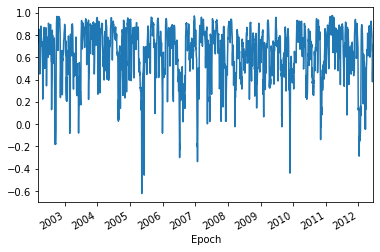

In [383]:
df_moments['GPS']['autocorr_1_15'].plot()

In [222]:
check_for_missing_vals(df_moments)

GPS
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Two class labels

In [86]:
y_2c = create_two_class_signal(prices, symbol_list)
y_2c = y_2c[max(input_window_size):-max(forecast_horizon)]
y_2c.shape

(2586, 9)

In [117]:
l1 = []
for y in y_2c.columns.get_level_values(0).unique():
    l = []
    for x in y_2c[y].columns:
        c = y_2c[y][x].value_counts()
        s = c[0] + c[1]
        l.append([c[0]/s, c[1]/s])
    l1.append(l)
pd.DataFrame(np.mean(np.array(l1), axis=0).T, index=pd.Index(['0', '1']), columns=y_2c.columns.get_level_values(1).unique())

,signal_1,signal_3,signal_5,signal_7,signal_10,signal_15,signal_20,signal_25,signal_30
0,0.496906,0.481052,0.469451,0.465197,0.477572,0.476025,0.472931,0.464037,0.465197
1,0.503094,0.518948,0.530549,0.534803,0.522428,0.523975,0.527069,0.535963,0.534803


# Three class labels

In [85]:
#%%timeit

sym_list = symbol_list[:]

#dicti = {}
y_3c, y_3op = create_three_class_signal(prices, symbol_list, threshold=threshold_list)
y_3c_test, y_3op_test = create_three_class_signal(prices, symbol_list, threshold=threshold_list)

# Remove first and last 30 entries
y_3c = y_3c[max(input_window_size):-max(forecast_horizon)]
y_3op = y_3op[max(input_window_size):-max(forecast_horizon)]
y_3c.shape

(2586, 9)

In [97]:
l1 = []
for y in y_3c.columns.get_level_values(0).unique():
    l = []
    for x in y_3c[y].columns:
        c = y_3c[y][x].value_counts()
        s = c[0] + c[1] + c[-1]
        l.append([c[-1]/s, c[0]/s, c[1]/s])
    l1.append(l)
pd.DataFrame(np.mean(np.array(l1), axis=0).T, index=pd.Index(['-1', '0', '1']), columns=y_3c.columns.get_level_values(1).unique())

,signal_1,signal_3,signal_5,signal_7,signal_10,signal_15,signal_20,signal_25,signal_30
-1,0.347641,0.324053,0.323279,0.318252,0.323279,0.315159,0.312838,0.311678,0.312452
0,0.289637,0.305878,0.295437,0.298144,0.295050,0.304718,0.312838,0.311678,0.303558
1,0.362722,0.370070,0.381284,0.383604,0.381671,0.380124,0.374323,0.376643,0.383991


# Scaling the features

In [171]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [223]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [224]:
scaled = scale.fit_transform(df_moments)

In [225]:
scaled.shape

(2586, 80)

In [317]:
X_scaled = pd.DataFrame(data=scaled, columns=df_moments.columns, index=df_moments.index)
#X_scaled = X

# Triple-barrier labelling methods

In [431]:
from atomm.Filters import cusum_filter
from atomm.Tools import get_daily_vol

In [539]:
data = pd.read_csv('../data/raw/dollar_bars.txt')
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [540]:
data.index

DatetimeIndex(['2015-01-01 23:00:23.723000', '2015-01-02 07:07:35.156000',
               '2015-01-02 09:35:57.204000', '2015-01-02 12:59:42.176000',
               '2015-01-02 14:19:33.847000', '2015-01-02 14:33:39.311000',
               '2015-01-02 14:42:28.315000', '2015-01-02 14:51:59.300000',
               '2015-01-02 15:01:45.497000', '2015-01-02 15:06:57.293000',
               ...
               '2016-12-30 20:57:19.151000', '2016-12-30 20:58:34.724000',
               '2016-12-30 20:59:16.663000', '2016-12-30 20:59:34.157000',
               '2016-12-30 20:59:50.345000', '2016-12-30 20:59:58.848000',
               '2016-12-30 21:00:00.352000', '2016-12-30 21:00:24.294000',
               '2016-12-30 21:03:03.027000', '2016-12-30 21:13:31.990000'],
              dtype='datetime64[ns]', name='date_time', length=24079, freq=None)

In [582]:
dd2 = get_daily_vol(prices['GPS'].Close)

error: "None of [DatetimeIndex(['2002-01-29', '2002-01-30', '2002-01-31', '2002-02-01',\n               '2002-02-04', '2002-02-05', '2002-02-06', '2002-02-07',\n               '2002-02-08', '2002-02-11',\n               ...\n               '2012-07-13', '2012-07-16', '2012-07-17', '2012-07-18',\n               '2012-07-19', '2012-07-20', '2012-07-23', '2012-07-24',\n               '2012-07-25', '2012-07-26'],\n              dtype='datetime64[ns]', name='Epoch', length=2644, freq=None)] are in the [index]"
please confirm no duplicate indices


In [579]:
dd2.head(50)

date_time
2015-01-04 23:20:12.567   2015-01-02 21:06:49.282
2015-01-05 03:37:42.912   2015-01-01 23:00:23.723
2015-01-05 08:21:37.801   2015-01-02 07:07:35.156
2015-01-05 10:27:41.882   2015-01-02 09:35:57.204
2015-01-05 12:42:45.989   2015-01-02 09:35:57.204
2015-01-05 13:42:46.868   2015-01-02 12:59:42.176
2015-01-05 14:11:08.578   2015-01-02 12:59:42.176
2015-01-05 14:30:57.874   2015-01-02 14:19:33.847
2015-01-05 14:37:05.979   2015-01-02 14:33:39.311
2015-01-05 14:40:42.612   2015-01-02 14:33:39.311
2015-01-05 14:44:56.036   2015-01-02 14:42:28.315
2015-01-05 14:49:36.175   2015-01-02 14:42:28.315
2015-01-05 14:54:26.286   2015-01-02 14:51:59.300
2015-01-05 14:57:13.616   2015-01-02 14:51:59.300
2015-01-05 15:01:57.494   2015-01-02 15:01:45.497
2015-01-05 15:07:29.012   2015-01-02 15:06:57.293
2015-01-05 15:13:09.655   2015-01-02 15:06:57.293
2015-01-05 15:22:28.576   2015-01-02 15:14:31.569
2015-01-05 15:29:07.142   2015-01-02 15:22:54.187
2015-01-05 15:35:09.056   2015-01-02 15:

In [480]:
(pd.Series(prices.index[dd - 1], index=prices.index[prices.shape[0] - dd.shape[0]:])).index

DatetimeIndex(['2002-01-30 00:00:00+00:00', '2002-01-31 00:00:00+00:00',
               '2002-02-01 00:00:00+00:00', '2002-02-04 00:00:00+00:00',
               '2002-02-05 00:00:00+00:00', '2002-02-06 00:00:00+00:00',
               '2002-02-07 00:00:00+00:00', '2002-02-08 00:00:00+00:00',
               '2002-02-11 00:00:00+00:00', '2002-02-12 00:00:00+00:00',
               ...
               '2012-07-17 00:00:00+00:00', '2012-07-18 00:00:00+00:00',
               '2012-07-19 00:00:00+00:00', '2012-07-20 00:00:00+00:00',
               '2012-07-23 00:00:00+00:00', '2012-07-24 00:00:00+00:00',
               '2012-07-25 00:00:00+00:00', '2012-07-26 00:00:00+00:00',
               '2012-07-27 00:00:00+00:00', '2012-07-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Epoch', length=2645, freq=None)

In [501]:
close = prices['GPS'][['Close']]
                      
dd.shape


(2644,)

# Train-Test Split

In [407]:
X_scaled = df_moments.copy()

In [408]:
# Use 70/30 train/test splits
test_p = .15

In [228]:
# Scaled, three-class
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = prices[:test_size], prices[test_size:]

In [409]:
# Unscaled, two-class
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_2c[:test_size], y_2c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [410]:
X_test.index.min()

Timestamp('2010-12-02 00:00:00+0000', tz='UTC')

In [231]:
# Scaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_2c[:test_size], y_2c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [ ]:
#test_size = test_p
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

# Model

In [411]:
symbol = 'GPS'
n = 15
# set up cross validation splits
tscv = TimeSeriesSplit(n_splits=5)
btscv = BlockingTimeSeriesSplit(n_splits=5)
#ppcv = PurgedKFold(n_splits=5)

## Single lookback/lookahead combination

### RF

In [412]:
n_estimator = 1000
depth = 2

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy',
                            class_weight='balanced_subsample',
                            random_state=101)
rf.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

y_pred_rf = rf.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print(classification_report(y_test[symbol][f'signal_{n}'], y_pred_rf))
print(confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_rf))

              precision    recall  f1-score   support

           0       0.45      0.63      0.52       159
           1       0.64      0.46      0.53       229

    accuracy                           0.53       388
   macro avg       0.54      0.54      0.53       388
weighted avg       0.56      0.53      0.53       388

[[100  59]
 [124 105]]


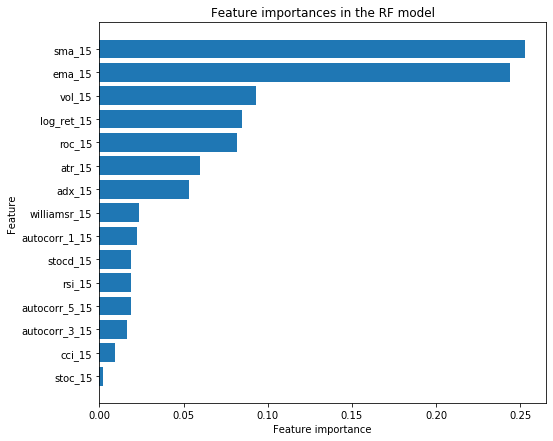

In [414]:
plot_feature_importances(
    rf.feature_importances_,                         
    columns=X_test[symbol][[f'{x}_{n}' for x in ti_list]].columns,
    model='RF',
    top_count=30,
)

### SVC

In [415]:
clf = SVC(C=1000, gamma=1E-5)
clf.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

y_pred_svc = clf.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print(classification_report(y_test[symbol][f'signal_{n}'], y_pred_svc))
print(confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_svc))
#plot_feature_importances(svc.coef_,
#                         X_scaled[symbol][[f'{x}_{n}' for x in ti_list]].columns, 
#                         model='SVC1', top_count=100)

              precision    recall  f1-score   support

           0       0.42      0.56      0.48       159
           1       0.60      0.45      0.52       229

    accuracy                           0.50       388
   macro avg       0.51      0.51      0.50       388
weighted avg       0.52      0.50      0.50       388

[[ 89  70]
 [125 104]]


In [416]:
clf = XGBClassifier(n_jobs=-1)
clf.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [417]:
y_pred_xgb = clf.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print(classification_report(y_test[symbol][f'signal_{n}'], y_pred_xgb))
print(confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_xgb))
#plot_feature_importances(svc.coef_,
#                         X_scaled[symbol][[f'{x}_{n}' for x in ti_list]].columns, 
#                         model='SVC1', top_count=100)

              precision    recall  f1-score   support

           0       0.41      0.48      0.44       159
           1       0.59      0.52      0.56       229

    accuracy                           0.51       388
   macro avg       0.50      0.50      0.50       388
weighted avg       0.52      0.51      0.51       388

[[ 76  83]
 [109 120]]


## All combinations

In [244]:
clf = XGBClassifier
score_xgb, returns_xgb = run_combinations(
    symbol=symbol,
    forecast_horizon=forecast_horizon,
    input_window_size=input_window_size,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    prices=prices_test,
    model=clf,
    hyper_optimize=True,
    n_eval=100
)

plot_corr_matrix(score_xgb, mask_upper=False, show_annot=True, figsize=(8, 8))

100%|██████████| 100/100 [02:13<00:00,  1.33s/it, best loss: -0.5470588235294118]


NameError: name 'calc_returns' is not defined

## Hyperparamter Optimization: Bayesian Optimization, SVC

In [423]:
n1=15
n2=15

model = SVC
score, clf_best, parameters_best = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n1}' for x in ti_list]], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][[f'{x}_{n1}' for x in ti_list]],
    y_test[symbol][f'signal_{n2}'],
    num_eval=500
)

100%|██████████| 500/500 [01:37<00:00,  5.11it/s, best loss: -0.6204545454545455]
##### Results #####
Score best parameters:  -0.6204545454545455
Best parameters:  {'C': 621.7042199088071, 'cv': 'btscv', 'gamma': 8.194914173527679e-14, 'model': <class 'sklearn.svm._classes.SVC'>, 'normalize': 0, 'scale': 0}
Test Score:  0.5902061855670103
Parameter combinations evaluated:  500
Time elapsed:  98.10294198989868


In [424]:
clf_best

SVC(C=621.7042199088071, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=8.194914173527679e-14, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

## Hyperparamter Optimization: Bayesian Optimization, XGB

In [422]:
n1=15
n2=15

model = XGBClassifier
bsearch_xgb = BayesianSearch(
    search_space(XGBClassifier),
    model,
    X_train[symbol][[f'{x}_{n1}' for x in ti_list]], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][[f'{x}_{n1}' for x in ti_list]],
    y_test[symbol][f'signal_{n2}'],
    num_eval=10
)

100%|██████████| 10/10 [01:11<00:00,  7.19s/it, best loss: -0.5795454545454546]
##### Results #####
Score best parameters:  -0.5795454545454546
Best parameters:  {'booster': 'gbtree', 'colsample_bytree': 0.6571346286826318, 'cv': 'btscv', 'gamma': 5, 'learning_rate': 43.51596522276907, 'max_depth': 179, 'model': <class 'xgboost.sklearn.XGBClassifier'>, 'n_estimators': 116, 'n_jobs': -1, 'subsample': 1}
Test Score:  0.5902061855670103
Parameter combinations evaluated:  10
Time elapsed:  72.14264488220215


## Hyperparamter Optimization: Bayesian Optimization, RF

In [426]:
n1=15
n2=15
num_eval=15

model = RandomForestClassifier
score, clf_best, parameters_best = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n1}' for x in ti_list]], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][[f'{x}_{n1}' for x in ti_list]],
    y_test[symbol][f'signal_{n2}'],
    num_eval=num_eval
)

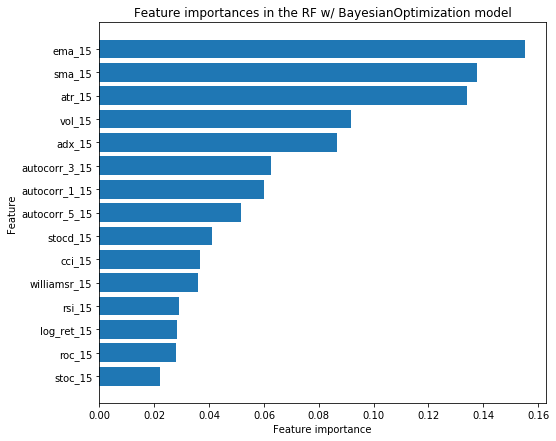

In [428]:
plot_feature_importances(
    clf_best.feature_importances_,                         
    columns=X_test[symbol][[f'{x}_{n}' for x in ti_list]].columns,
    model='RF w/ BayesianOptimization',
    top_count=30,
)

In [ ]:
## 

In [327]:
n1=15
n2=15
num_eval=100

model = KNeighborsClassifier
bsearch_svm = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n1}' for x in ti_list]], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][[f'{x}_{n1}' for x in ti_list]],
    y_test[symbol][f'signal_{n2}'],
    num_eval=num_eval
)

100%|██████████| 100/100 [01:01<00:00,  1.62it/s, best loss: -0.5802318801952324]
##### Results #####
Score best parameters:  -0.5802318801952324
Best parameters:  {'cv': 'cv', 'model': <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, 'n_jobs': -1, 'n_neighbors': 61, 'normalize': 0, 'p': 8, 'scale': 0}
Test Score:  0.4882903981264637
Parameter combinations evaluated:  100
Time elapsed:  62.092283964157104


## Running on all 50 stocks

In [158]:
best_params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 218, 'max_features': 1, 'min_samples_leaf': 19, 'n_estimators': 423}
model_2a = RandomForestClassifier(n_jobs=-1, **best_params)
avg, _, _ = avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=model_2a,
    silent = False
)

'Leg [50/50]; Elapsed Time 2475.0s\n'

,3,5,7,10,15,20,25,30
1,0.507666,0.504838,0.504157,0.505792,0.504872,0.507462,0.506099,0.504055
3,0.511073,0.508245,0.510903,0.506133,0.507632,0.507802,0.508177,0.504974
5,0.514378,0.511652,0.511141,0.513629,0.516082,0.516695,0.51891,0.516082
7,0.516082,0.516491,0.516593,0.515639,0.519625,0.520307,0.519216,0.521193
10,0.517172,0.515945,0.515264,0.513254,0.518228,0.519932,0.519387,0.517581
15,0.524497,0.520852,0.522044,0.522215,0.524259,0.531687,0.525894,0.522964
20,0.52678,0.527325,0.529063,0.527802,0.529744,0.525213,0.521942,0.521772
25,0.528382,0.527121,0.530801,0.535128,0.532164,0.524872,0.523952,0.526269
30,0.535945,0.537922,0.537206,0.537956,0.538024,0.531857,0.532913,0.535196


In [159]:
avg

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535
